In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import math
# Apply the default theme
sns.set_theme()

import os
from pathlib import Path
import itertools
from data import name_to_dataset

RESULTS_PATH = 'results/'

MODELS = [
    'LogisticRegression',
    'SVMClassifier',
    'DecisionTree2',
    'DecisionTree4',
    'DecisionTree8',
    'DecisionTree16',
    'DecisionTree',
    'RandomForest2',
    'RandomForest4',
    'RandomForest8',
    'RandomForest16',
    'RandomForest',
    'XGBoost',
    #'MLP'
    ]

HIER_TYPES = ['rsa', 'ras', 'asr', 'ers', 'esr', 'res', 'ser']
HIER_STATES = ['NY', 'IL', 'FL', 'CA']
HIER_TASKS = ['income', 'coverage', 'employment']

In [78]:
def load_error_results(dataset, model, group_indices):
    path = os.path.join(os.path.join(RESULTS_PATH, dataset), 
                        "{}.pt".format(model))
    
    return_dict = {}
    groups = group_indices
    return_dict['name'] = dataset
    return_dict['groups'] = groups
    raw_results = torch.load(path)

    # Convert format of results
    return_dict['results'] = {}
    result_keys = ['ERM_ALL', 'ERM_GROUP', 'TREE', 'PREPEND']
    for g in groups:
        erm_all_results = raw_results[g]['ERM_ALL']
        if erm_all_results[0] == -1: # indicator that group was empty
            return_dict['results'][g] = {}
            for method in result_keys:
                return_dict['results'][g][method] = (0, 0)
        else:
            return_dict['results'][g] = {}
            for method in result_keys:
                results = raw_results[g][method]
                err = results[0] - results[1][0]
                return_dict['results'][g][method] = (results[0], err)
    return return_dict

In [79]:
def dataset_error_df(models, dataset, groups):
    """
    Creates a dataframe for each fixed dataset with the error data for each model. Columns are the groups, rows are the models.
    """
    # Construct columns
    rows = []
    for model in models:
        rows.append("{} (ERM)".format(model))
        rows.append("{} (G-ERM)".format(model))
        rows.append("{} (PREP)".format(model))
        rows.append("{} (TREE)".format(model))
    df = pd.DataFrame(index=rows, columns=groups)
    df_errs = pd.DataFrame(columns=groups)

    for model in models:
        results = load_error_results(dataset, model, groups)
        group_errors = results['results']
        erm_row = []
        erm_row_err = []
        germ_row = []
        germ_row_err = []
        prep_row = []
        prep_row_err = []
        tree_row = []
        tree_row_err = []
        for g in groups:
            erm_row.append(group_errors[g]['ERM_ALL'][0])
            erm_row_err.append(group_errors[g]['ERM_ALL'][1])
            germ_row.append(group_errors[g]['ERM_GROUP'][0])
            germ_row_err.append(group_errors[g]['ERM_GROUP'][1])
            prep_row.append(group_errors[g]['PREPEND'][0])
            prep_row_err.append(group_errors[g]['PREPEND'][1])
            tree_row.append(group_errors[g]['TREE'][0])
            tree_row_err.append(group_errors[g]['TREE'][1])

        df.loc["{} (ERM)".format(model)] = erm_row
        df_errs.loc["{} (ERM) err".format(model)] = erm_row_err
        df.loc["{} (G-ERM)".format(model)] = germ_row
        df_errs.loc["{} (G-ERM) err".format(model)] = germ_row_err
        df.loc["{} (PREP)".format(model)] = prep_row
        df_errs.loc["{} (PREP) err".format(model)] = prep_row_err
        df.loc["{} (TREE)".format(model)] = tree_row
        df_errs.loc["{} (TREE) err".format(model)] = tree_row_err

    df = pd.concat([df, df_errs]).transpose() # groups should be rows
    return df

def plot_error(ax, data, models, groups, 
               group_names=None, title=None, legend=False):
    # Preprocess the data into a vertical DF
    rows = []
    for (group, model) in itertools.product(groups, models):
        row = {}
        row['group'] = group
        row['model'] = model
        row['error'] = data.loc[group][model]
        err = data.loc[group]["{} err".format(model)]
        lerr = err
        uerr = min([1.0 - data.loc[group][model], err])
        row['lerr'] = lerr
        row['uerr'] = uerr
        rows.append(row)

    df = pd.DataFrame(rows)

    # Plot the data
    err = []
    lerr = df.pivot(index='group', columns='model', values='lerr')
    uerr = df.pivot(index='group', columns='model', values='uerr')
    for col in lerr:
        err.append([lerr[col].values, uerr[col].values])
    p = df.pivot(index='group', columns='model', values='error')

    # Rename the index
    renamed_idx = {}
    for i, g in enumerate(groups):
        renamed_idx[g] = group_names[i]
    p = p.rename(index=renamed_idx)
    ax = p.plot(kind='bar', yerr=err, ax=ax, legend=False)
    ax.set_ylabel('test error')
    if title:
        ax.set_title(title)
    if legend:
        ax.legend(loc='lower center', frameon=False, ncols=4, bbox_to_anchor=(0, -1.0, 0.5, 0.5))
    return ax

In [80]:
def plot_errors_tree(dataset, df, models, group_names, tree, plots_per_row):
    rows = int(math.ceil(len(tree[3])/plots_per_row))
    fig, axs = plt.subplots(2 + rows, figsize=(10,15))
    fig.suptitle("Hierarchical Group Errors for {}".format(dataset),fontsize=12)
    group_indices = list(df.index)

    # Level 1
    axs[0] = plot_error(axs[0], df, models, 
                        [group_indices[i] for i in tree[0] + tree[1]],
                        [group_names[i] for i in tree[0] + tree[1]],
                        title=None, legend=False)
    # Level 2
    axs[1] = plot_error(axs[1], df, models,
                        [group_indices[i] for i in tree[2]],
                        [group_names[i] for i in tree[2]],
                        title=None, legend=False)

    # Need more rows for Level 3
    start = 0
    stop = plots_per_row
    for i in range(2, 2 + rows):
        axs[i] = plot_error(axs[i], df, models,
                        [group_indices[j] for j in tree[3][start:stop]],
                        [group_names[j] for j in tree[3][start:stop]],
                        title=None, legend=False)
        start += plots_per_row
        stop += plots_per_row
    
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.75),
                  fancybox=True, shadow=False, ncol=len(models)/2)
    plt.tight_layout()
    plt.show()

## Hierarchical Groups

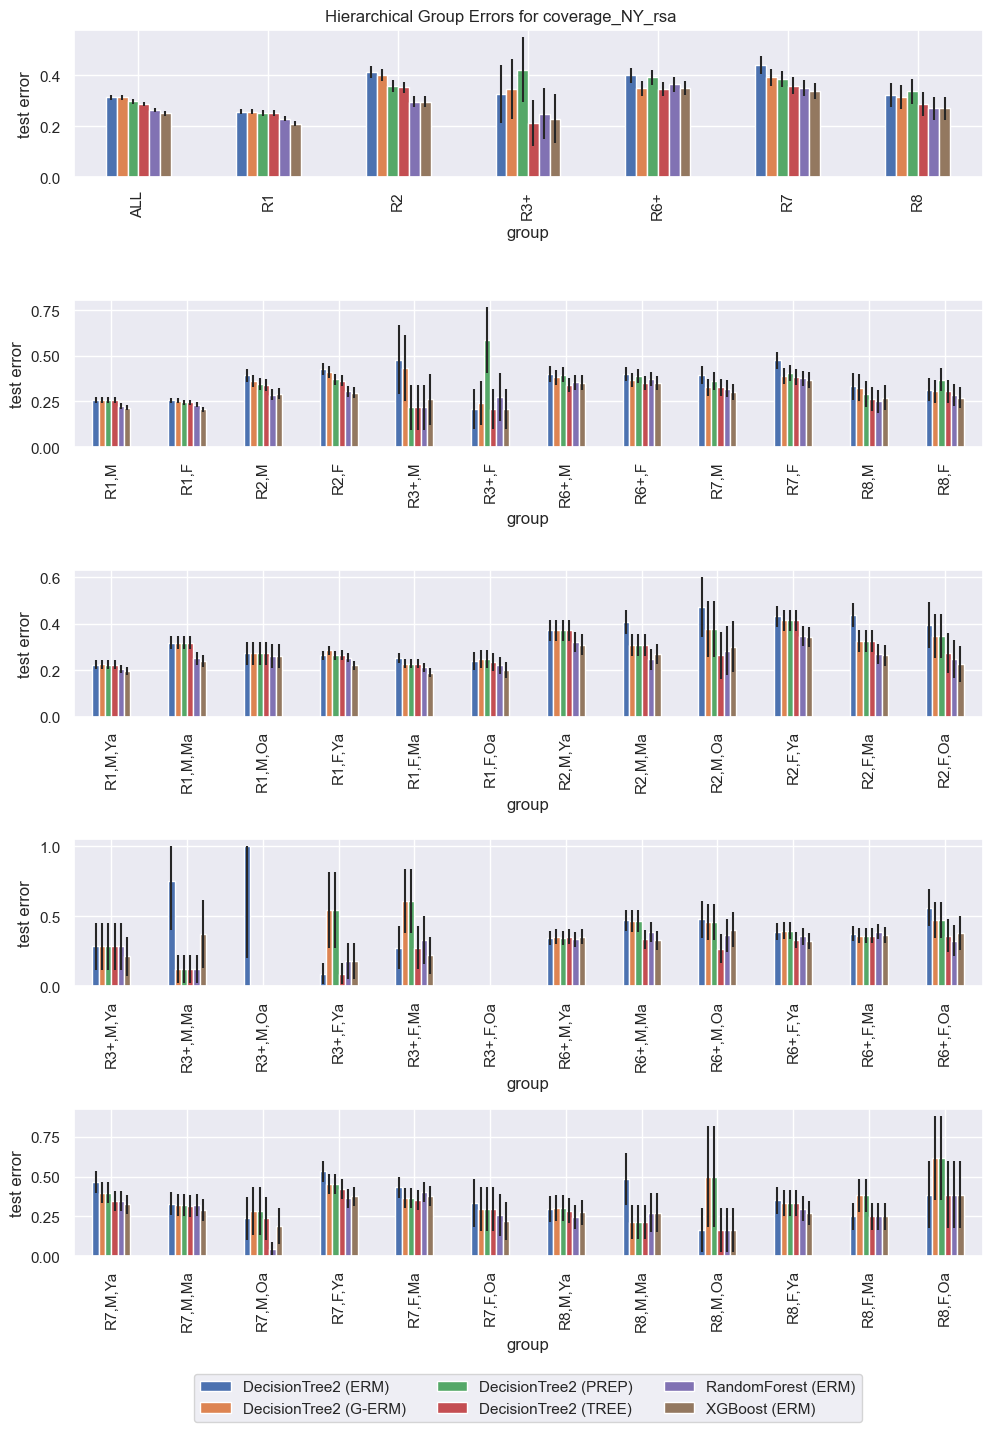

In [82]:
task = 'coverage'
state = 'NY'
hier = 'rsa'

dataset = '{}_{}_{}'.format(task, state, hier)
dataset_obj = name_to_dataset('income_IL_{}'.format(hier))
tree = dataset_obj.tree
group_indices = list(range(len(dataset_obj.group_names)))

base_hypothesis = 'DecisionTree2'
models = ['{} (ERM)'.format(base_hypothesis), 
          '{} (G-ERM)'.format(base_hypothesis), 
          '{} (TREE)'.format(base_hypothesis),
          '{} (PREP)'.format(base_hypothesis),
          'RandomForest (ERM)',
          'XGBoost (ERM)']

df = dataset_error_df(MODELS, dataset, group_indices)
plot_errors_tree(dataset, df, models, dataset_obj.group_names, tree, 12)

## Region (Race)

In [83]:
dataset_obj = name_to_dataset('employment_ST_race')
group_names = dataset_obj.group_names
tree = dataset_obj.tree

helloooo


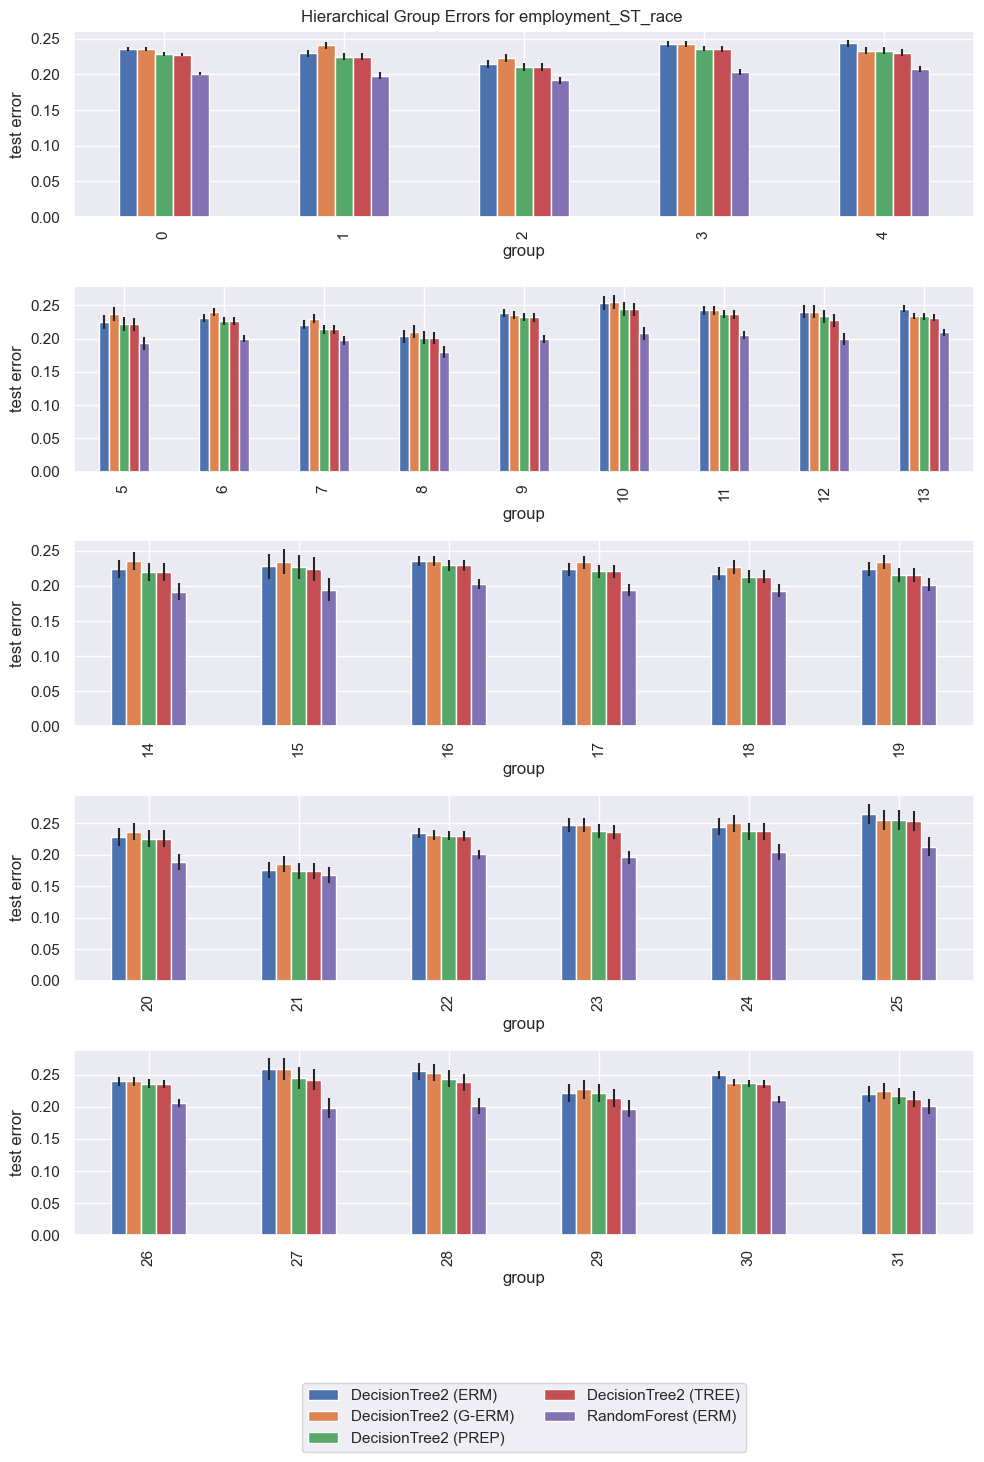

In [87]:
task = 'employment'
dataset = '{}_ST_race'.format(task)
tree = dataset_obj.tree
group_indices = list(range(len(dataset_obj.group_names)))

base_hypothesis = 'DecisionTree2'
models = ['{} (ERM)'.format(base_hypothesis), 
          '{} (G-ERM)'.format(base_hypothesis), 
          '{} (TREE)'.format(base_hypothesis),
          '{} (PREP)'.format(base_hypothesis),
          'RandomForest (ERM)']

df = dataset_error_df(MODELS, dataset, group_indices)
plot_errors_tree(dataset, df, models, group_indices, tree, 6)

In [35]:
results = load_error_results('employment_ST_race', 'LogisticRegression', group_indices)

{'name': 'employment_ST_race',
 'groups': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139],
 'results': {0: {'ERM_ALL': (0.19522783548252243, 0.002237935311559469),
   'ERM_GROUP':

## Region (Sex)

## 

In [3]:
group_indices = list(range(len(group_names)))

In [36]:
results = load_error_results('employment_ST_race', 'LogisticRegression', group_indices)

In [45]:
results['results'][50]

{'ERM_ALL': (0.19380306867272457, 0.009465292058243063),
 'ERM_GROUP': (0.18873826903023982, 0.009365329287300328),
 'TREE': (0.18814241024877104, 0.009353398966900073),
 'PREPEND': (0.18873826903023982, 0.009365329287300328)}

In [24]:
results['results'][30]

{'ERM_ALL': (0.20663995420721237, 0.005321577883692391),
 'ERM_GROUP': (0.20708026947294264, 0.005325883105839924),
 'TREE': (0.20628770199462815, 0.005318126732616557),
 'PREPEND': (0.2070362379463696, 0.005325453018877213)}

In [19]:
group_names

['ALL',
 'NORTHEAST',
 'MIDWEST',
 'SOUTH',
 'WEST',
 'NORTHEAST,NewEngland',
 'NORTHEAST,MidAtlantic',
 'MIDWEST,EastNorthCentral',
 'MIDWEST,WestNorthCentral',
 'SOUTH,SouthAtlantic',
 'SOUTH,EastSouthCentral',
 'SOUTH,WestSouthCentral',
 'WEST,Mountain',
 'WEST,Pacific',
 'NORTHEAST,NewEngland,MA',
 'NORTHEAST,NewEngland,CT',
 'NORTHEAST,MidAtlantic,NY',
 'NORTHEAST,MidAtlantic,PA',
 'MIDWEST,EastNorthCentral,IL',
 'MIDWEST,EastNorthCentral,OH',
 'MIDWEST,WestNorthCentral,MO',
 'MIDWEST,WestNorthCentral,MN',
 'SOUTH,SouthAtlantic,FL',
 'SOUTH,SouthAtlantic,GA',
 'SOUTH,EastSouthCentral,TN',
 'SOUTH,EastSouthCentral,AL',
 'SOUTH,WestSouthCentral,TX',
 'SOUTH,WestSouthCentral,LA',
 'WEST,Mountain,AZ',
 'WEST,Mountain,CO',
 'WEST,Pacific,CA',
 'WEST,Pacific,WA',
 'NORTHEAST,NewEngland,MA,R1',
 'NORTHEAST,NewEngland,MA,R2',
 'NORTHEAST,NewEngland,MA,R3+',
 'NORTHEAST,NewEngland,MA,R6+',
 'NORTHEAST,NewEngland,MA,R7',
 'NORTHEAST,NewEngland,MA,R8',
 'NORTHEAST,NewEngland,CT,R1',
 'NORTHE